In [1]:
!pip install cohere
!pip install altair
!pip install altair-data-server

  Preparing metadata (setup.py) ... done
  Created wheel for cohere: filename=cohere-2.2.5-cp37-cp37m-macosx_10_9_x86_64.whl size=10460 sha256=913f55b575e857c8ca73ab4257071a3b8903f761caef03bc4df306d2edf18b68
  Stored in directory: /Users/ankush.singal/Library/Caches/pip/wheels/eb/19/2d/89553daf06bc949f1aeb4cfae6e1e306d7763b22ffe91e45fa
Successfully built cohere


In [2]:
!pip install annoy

In [3]:
#@title Import libraries (Run this cell to execute required code) {display-mode: "form"}
import cohere
import numpy as np
import re
import pandas as pd
from tqdm import tqdm
#from datasets import load_dataset
import umap
import altair as alt
from sklearn.metrics.pairwise import cosine_similarity
from annoy import AnnoyIndex
import warnings
from sklearn.cluster import KMeans
from bertopic._ctfidf import ClassTFIDF
from sklearn.feature_extraction.text import CountVectorizer

warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)

In [4]:
#Load the embeddings matrix
embeds = np.load('askhn3k_embeds.npy')
df = pd.read_csv('databricks2.csv',usecols=['title'])
df1 = df.sample(n=3000,random_state=1) 
print(f'Loaded a DataFrame with {len(df1)} rows and an embeddings matrix of dimensions {embeds.shape}')

Loaded a DataFrame with 3000 rows and an embeddings matrix of dimensions (3000, 1024)


In [5]:
df1.reset_index(inplace=True)

# Building a semantic search index
For nearest-neighbor search, we can use the open-source Annoy library. Let's create a semantic search index and feed it all the embeddings.

In [6]:
# Create the search index, pass the size of embedding
search_index = AnnoyIndex(embeds.shape[1], 'angular')
# Add all the vectors to the search index
for i in range(len(embeds)):
    search_index.add_item(i, embeds[i])

search_index.build(10) # 10 trees
search_index.save('askhn.ann')

True

# 1- Given an existing post title, retrieve the most similar posts (nearest neighbor search using embeddings)
We can query neighbors of a specific post using get_nns_by_item.

In [7]:
# Choose an example (we'll retrieve others similar to it)
example_id = 50

# Retrieve nearest neighbors
similar_item_ids = search_index.get_nns_by_item(example_id,
                                                10, # Number of results to retrieve
                                                include_distances=True)

# Format and print the text and distances
results = pd.DataFrame(data={'post titles': df1.iloc[similar_item_ids[0]]['title'], 
                             'distance': similar_item_ids[1]}).drop(example_id)

print(f"Query post:'{df1.iloc[example_id]['title']}'\nNearest neighbors:")
results

Query post:'2203220030000505'
Nearest neighbors:


,post titles,distance
731,Feature Store API in Docker,0.782082
2691,Failure to add user to a Databricks workspace with an error,0.832201
1859,What cluster manager types on Spark on Databricks,0.832643
1965,Unable to start a cluster,0.932350
2123,job failure/long running without change to job.,0.967258
2910,Can we send a failure with the error logs when job failed,0.976471
1603,2204250010000575 | SPN secret,0.979501
2599,Docker image pull failure ECR,0.987894
1206,[ARR][ADOBE][2203100010002839 ]Need increase TBL_NAME column size in databricks meta store,0.997030


# 3- Plot the archive of articles by similarity
What if we want to browse the archive instead of only searching it. Let's plot out all the questions onto a 2D chart so you're able to visualize the posts in the archive and their similarities.

In [8]:
!pip install umap-learn

In [9]:
reducer = umap.UMAP(n_neighbors=100) 
umap_embeds = reducer.fit_transform(embeds)


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [10]:
df1['x'] = umap_embeds[:,0]
df1['y'] = umap_embeds[:,1]

# Plot
chart = alt.Chart(df1).mark_circle(size=60).encode(
    x=#'x',
    alt.X('x',
        scale=alt.Scale(zero=False),
        axis=alt.Axis(labels=False, ticks=False, domain=False)
    ),
    y=
    alt.Y('y',
        scale=alt.Scale(zero=False),
        axis=alt.Axis(labels=False, ticks=False, domain=False)
    ),
    tooltip=['title']
).configure(background="#FDF7F0"
).properties(
    width=700,
    height=400,
    title='Ask HN: top 3,000 posts'
)

chart.interactive()

alt.Chart(...)

# 4- Cluster the posts to identify the major common themes
Let's proceed the cluster the embeddings using KMeans from scikit-learn.

In [11]:
# Pick the number of clusters
n_clusters=8

# Cluster the embeddings
kmeans_model = KMeans(n_clusters=n_clusters, random_state=0)
classes = kmeans_model.fit_predict(embeds)

In [12]:
classes

array([7, 5, 0, ..., 5, 7, 0], dtype=int32)

In [13]:
import altair as alt
alt.data_transformers.enable('data_server')

DataTransformerRegistry.enable('data_server')

In [14]:
# Extract the keywords for each cluster
documents =  df1['title']
documents = pd.DataFrame({"Document": documents,
                          "ID": range(len(documents)),
                          "Topic": None})
documents['Topic'] = classes
documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
count_vectorizer = CountVectorizer(stop_words="english").fit(documents_per_topic.Document)
count = count_vectorizer.transform(documents_per_topic.Document)
words = count_vectorizer.get_feature_names()
ctfidf = ClassTFIDF().fit_transform(count).toarray()
words_per_class = {label: [words[index] for index in ctfidf[label].argsort()[-10:]] for label in documents_per_topic.Topic}
df1['cluster'] = classes
df1['keywords'] = df1['cluster'].map(lambda topic_num: ", ".join(np.array(words_per_class[topic_num])[:]))
#Plot with clusters and keywords information

In [15]:
df1.head()

,index,title,x,y,cluster,keywords
0,2624,Deprecated Cluster Runtime 6.4 unable to hit API'S,6.804984,4.725465,7,"error, workspace, access, failure, jobs, job, arr, unable, cluster, databricks"
1,5493,Heartbeat issues for larger dataset,6.361811,3.225446,5,"jobs, sql, failing, issue, failure, error, arr, job, cluster, databricks"
2,5565,Delta files saving data type as String for Boolean column,9.575385,2.680216,0,"data, sql, unable, jobs, issue, cluster, error, arr, job, databricks"
3,3553,Databricks Spring Core Vulnerability Impact,6.184659,2.479959,5,"jobs, sql, failing, issue, failure, error, arr, job, cluster, databricks"
4,1198,Not able to create JDBC connection,9.715446,6.891146,3,"workspace, spark, cluster, query, sql, error, unable, job, arr, databricks"


In [16]:
selection = alt.selection_multi(fields=['keywords'], bind='legend')

chart = alt.Chart(df1).transform_calculate(
    url='https://news.ycombinator.com/item?id=' + alt.datum.id
).mark_circle(size=60, stroke='#666', strokeWidth=1, opacity=0.3).encode(
    x=#'x',
    alt.X('x',
        scale=alt.Scale(zero=False),
        axis=alt.Axis(labels=False, ticks=False, domain=False)
    ),
    y=
    alt.Y('y',
        scale=alt.Scale(zero=False),
        axis=alt.Axis(labels=False, ticks=False, domain=False)
    ),
    href='url:N',
    color=alt.Color('keywords', 
                    legend=alt.Legend(columns=1, symbolLimit=0, labelFontSize=14)
                   ),
    opacity=alt.condition(selection, alt.value(1), alt.value(0.2)),
    tooltip=['title', 'keywords', 'cluster']
).properties(
    width=800,
    height=500
).add_selection(
    selection
).configure_legend(labelLimit= 0).configure_view(
    strokeWidth=0
).configure(background="#FDF7F0").properties(
    title='Data'
)
chart.interactive()

alt.Chart(...)

In [17]:
import scipy.cluster.hierarchy as hierarchy

In [18]:
df1.keywords.value_counts()


jobs, delta, sql, spark, failing, job, error, arr, cluster, databricks            562
data, sql, unable, jobs, issue, cluster, error, arr, job, databricks              539
jobs, sql, failing, issue, failure, error, arr, job, cluster, databricks          414
data, access, failing, error, job, issue, sql, cluster, arr, databricks           391
sql, data, failing, issue, unable, error, cluster, arr, job, databricks           336
error, workspace, access, failure, jobs, job, arr, unable, cluster, databricks    327
workspace, spark, cluster, query, sql, error, unable, job, arr, databricks        224
sql, sr, jobs, job, table, issue, cluster, arr, error, databricks                 207
Name: keywords, dtype: int64

In [19]:
label_list = ['jobs, delta, sql, spark, failing, job, error, arr, cluster, databricks','data, sql, unable, jobs, issue, cluster, error, arr, job, databricks  '
              'jobs, sql, failing, issue, failure, error, arr, job, cluster, databricks','data, access, failing, error, job, issue, sql, cluster, arr, databricks',
              'sql, data, failing, issue, unable, error, cluster, arr, job, databricks','error, workspace, access, failure, jobs, job, arr, unable, cluster, databricks','workspace, spark, cluster, query, sql, error, unable, job, arr, databricks',
              'sql, sr, jobs, job, table, issue, cluster, arr, error, databricks']

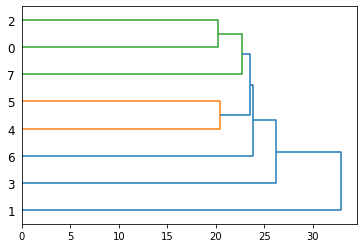

In [20]:
Z = hierarchy.linkage(kmeans_model.cluster_centers_, 'single')
dn = hierarchy.dendrogram(Z, orientation='right'
                         )
  

In [71]:
#https://txt.cohere.ai/combing-for-insight-in-10-000-hacker-news-posts-with-text-clustering/

In [83]:
#https://os.cohere.ai/